### Returns을 찍어보자

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from scipy.stats import stats

In [2]:
mktcap_before = pd.read_pickle("clean_mktcap.pickle")
price_before = pd.read_pickle("clean_price.pickle")

In [3]:
# pct를 구해줌
pct = price_before.pct_change(fill_method=None)
pct_3days = price_before.pct_change(3, fill_method=None) \
               .resample("3D").first()
pct_weekly = price_before.pct_change(7, fill_method=None) \
                  .resample("W").first()

# 시총 weights 계산
mktcap_3days = mktcap_before.resample("3D").first()
mktcap_weekly = mktcap_before.resample("W").first()

weight_daily = mktcap_before.apply(lambda x: x / np.nansum(x), axis=1)
weight_3days = mktcap_3days.apply(lambda x: x/ np.nansum(x), axis=1)
weight_weekly = mktcap_weekly.apply(lambda x: x/ np.nansum(x), axis=1)

# nan처리를 위한 masking 생성
sign_daily = np.sign(price_before)
sign_3days = np.sign(price_before.loc[pct_3days.index[:-1]])
sign_weekly = np.sign(price_before.loc[pct_weekly.index[:-1]])

# masking을 해준 pct_change 데이터프레임을 생성
rtn_daily = sign_daily * pct
rtn_3days = sign_3days * pct_3days
rtn_weekly = sign_weekly * pct_weekly

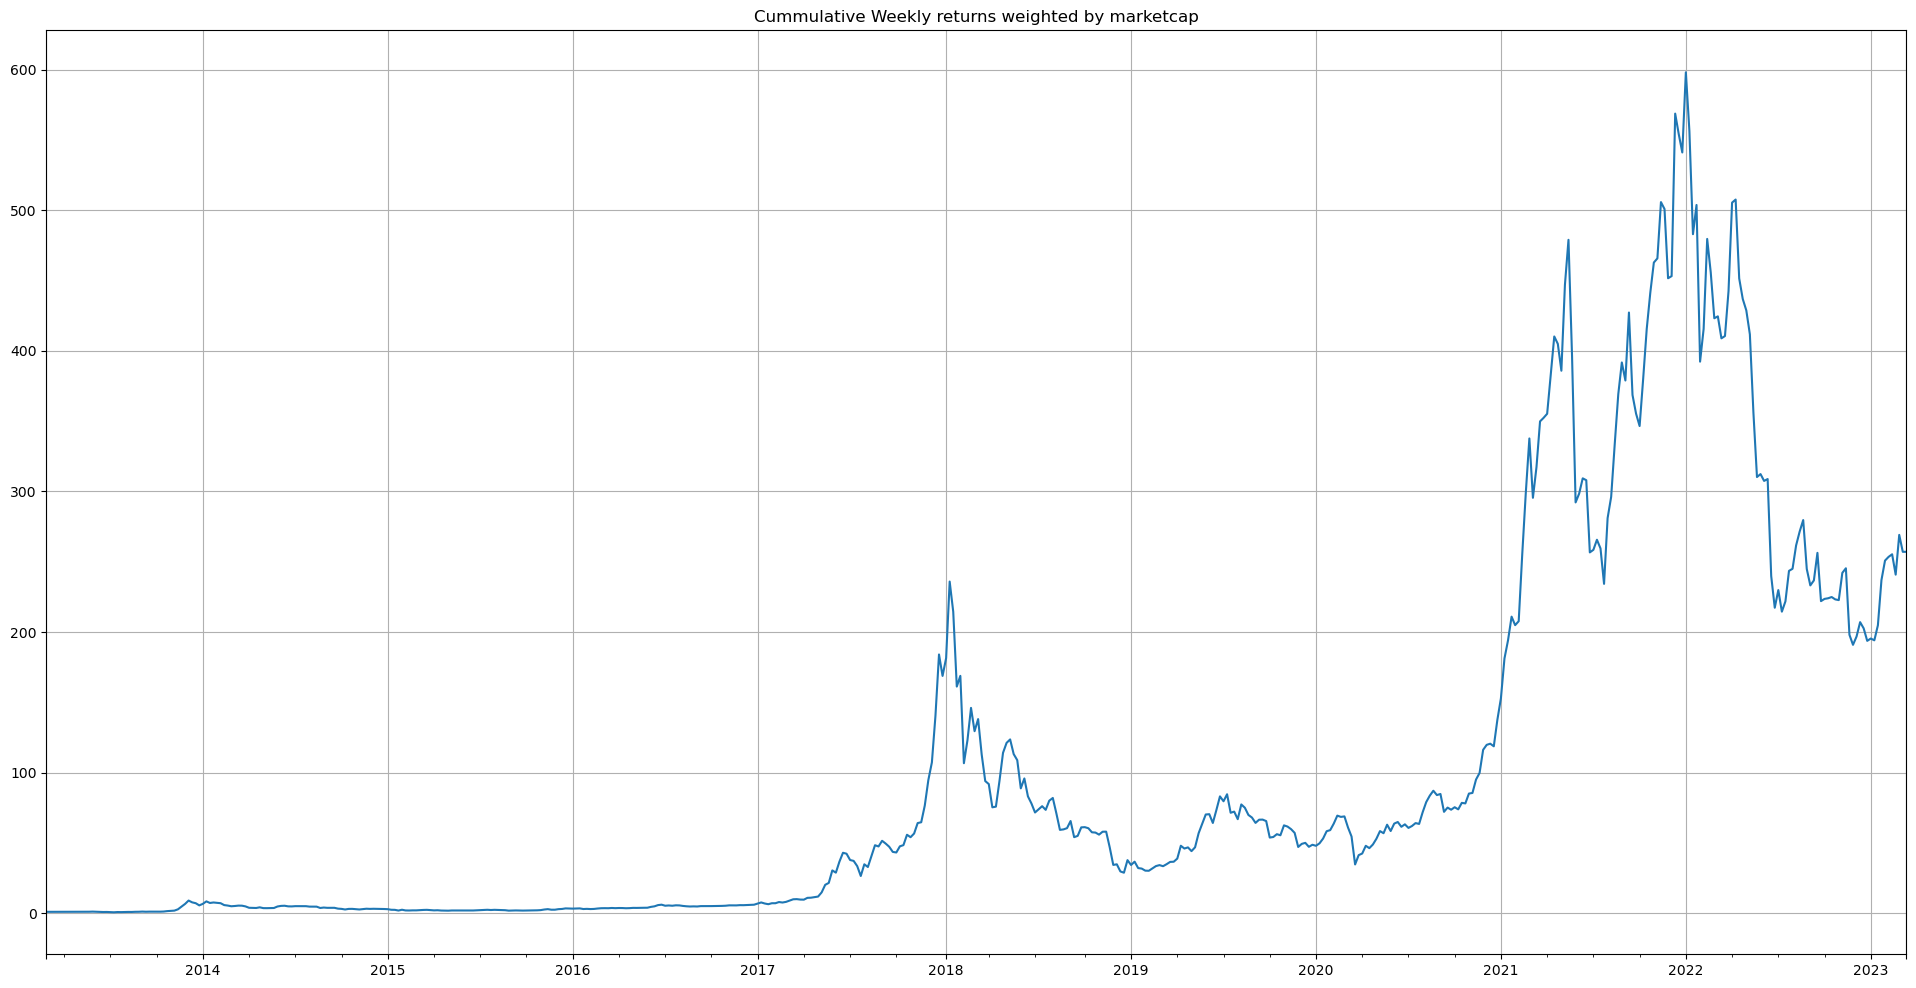

In [4]:
# mktcap 가중평균한 weekly returns
mkt_weekly = ((rtn_weekly * weight_weekly.shift(1)).sum(axis=1))
(mkt_weekly+1).cumprod().plot(figsize=(24,12))
plt.title("Cummulative Weekly returns weighted by marketcap")
plt.grid();

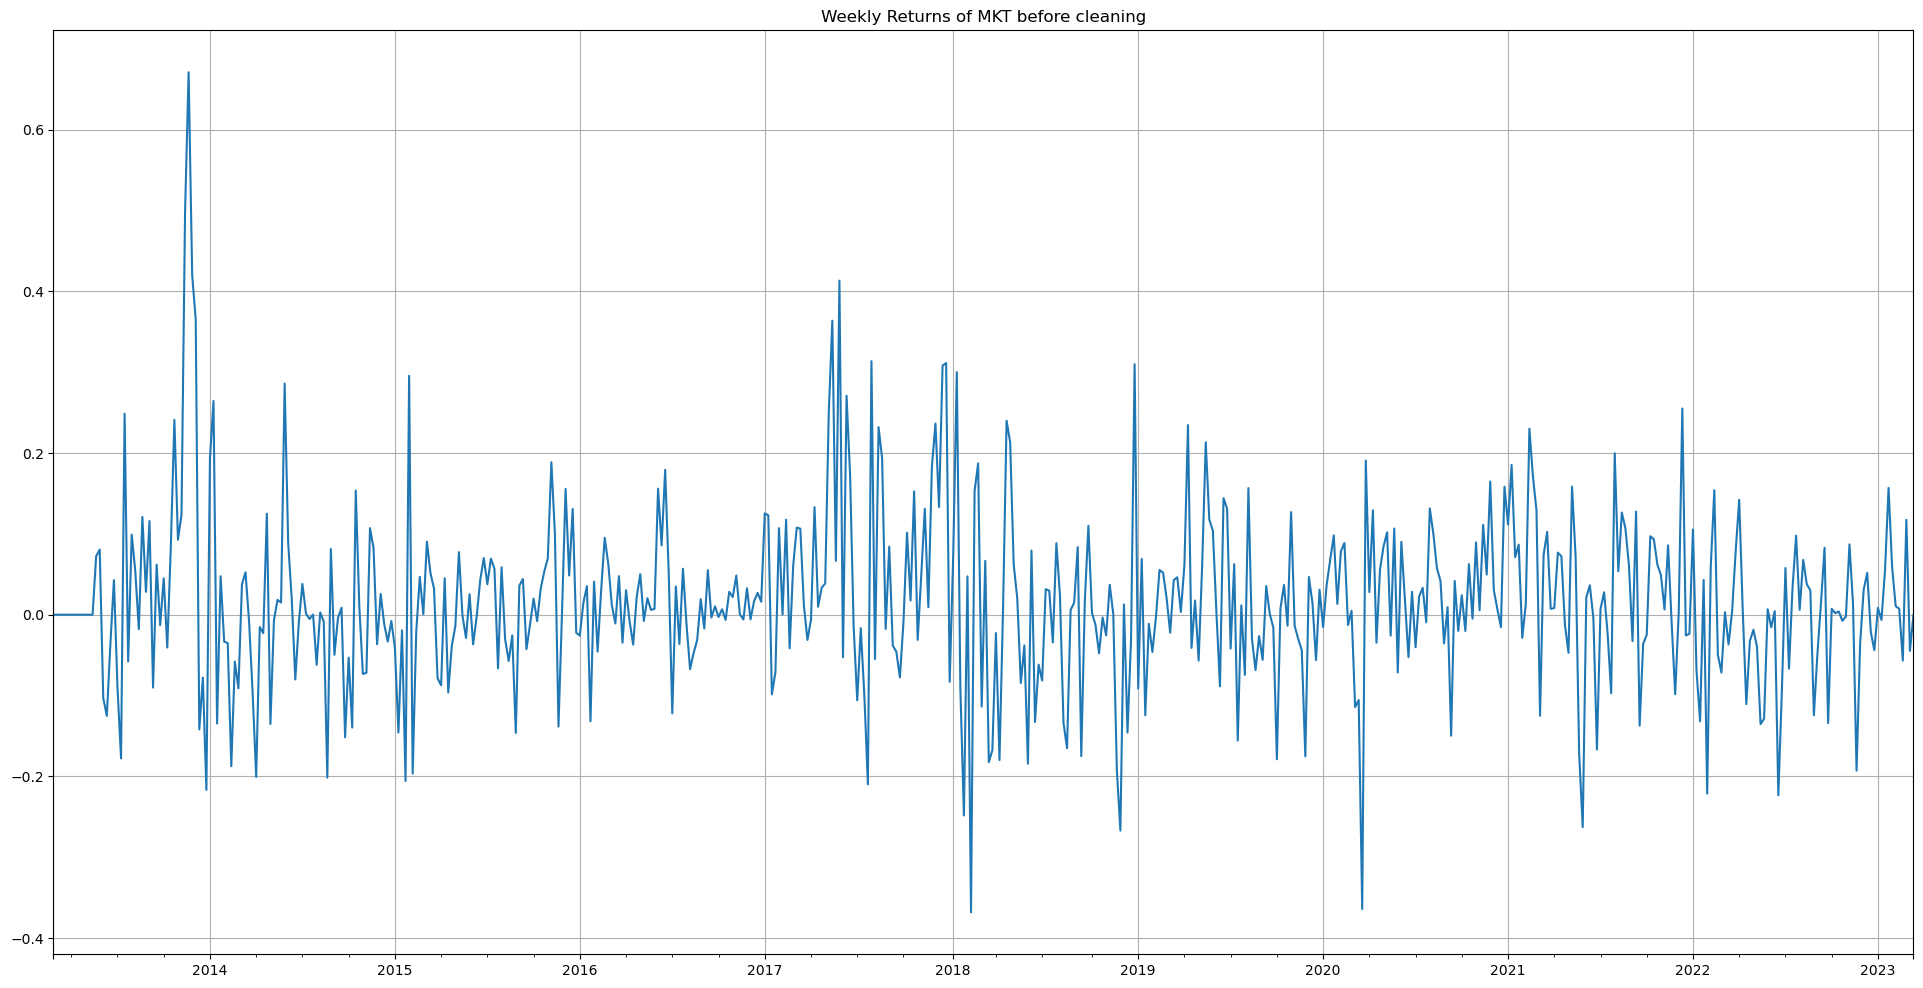

In [5]:
mkt_weekly.plot(figsize=(24,12))
plt.title("Weekly Returns of MKT before cleaning")
plt.grid();

In [12]:
mkt_weekly.cummax()

2013-03-03    0.000000
2013-03-10    0.000000
2013-03-17    0.000000
2013-03-24    0.000000
2013-03-31    0.000000
                ...   
2023-02-12    0.670924
2023-02-19    0.670924
2023-02-26    0.670924
2023-03-05    0.670924
2023-03-12    0.670924
Length: 524, dtype: float64

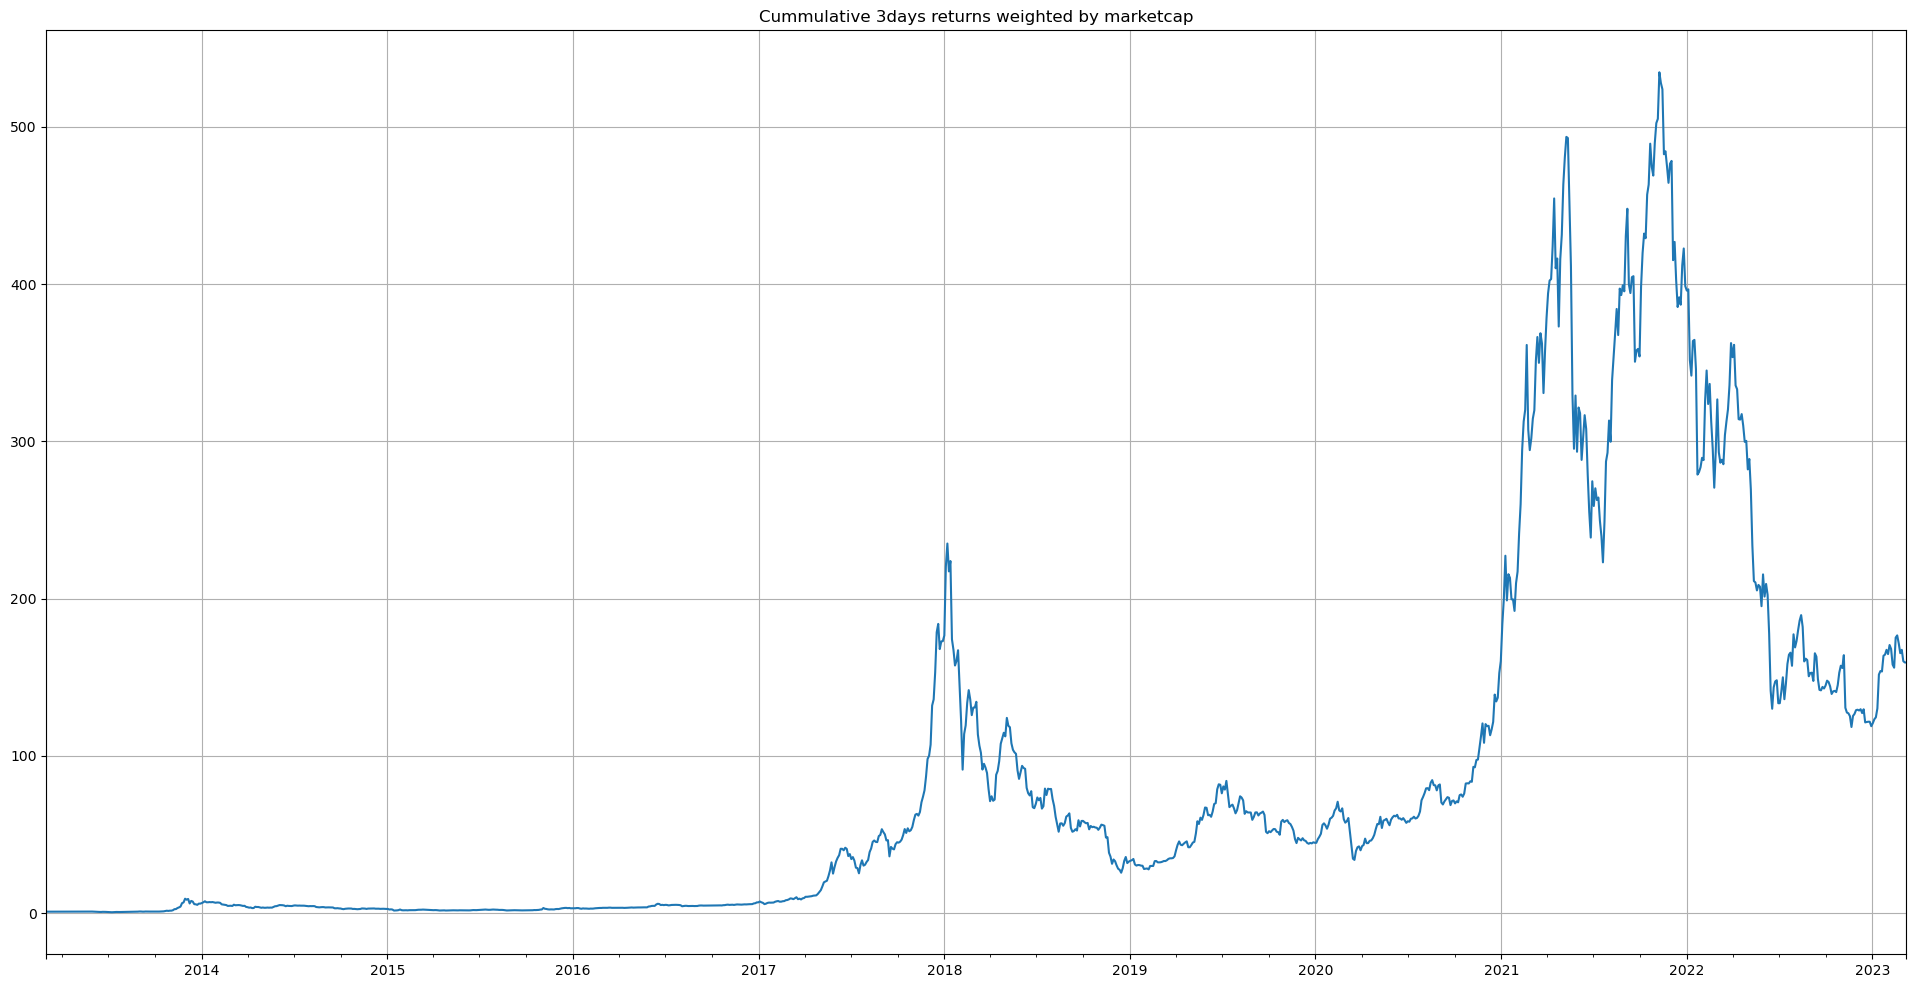

In [6]:
# 3days mkt return (시총 가중평균)
mkt_3days = ((rtn_3days * weight_3days.shift(1)).sum(axis=1))
(mkt_3days+1).cumprod().plot(figsize=(24,12))
plt.title("Cummulative 3days returns weighted by marketcap")
plt.grid();

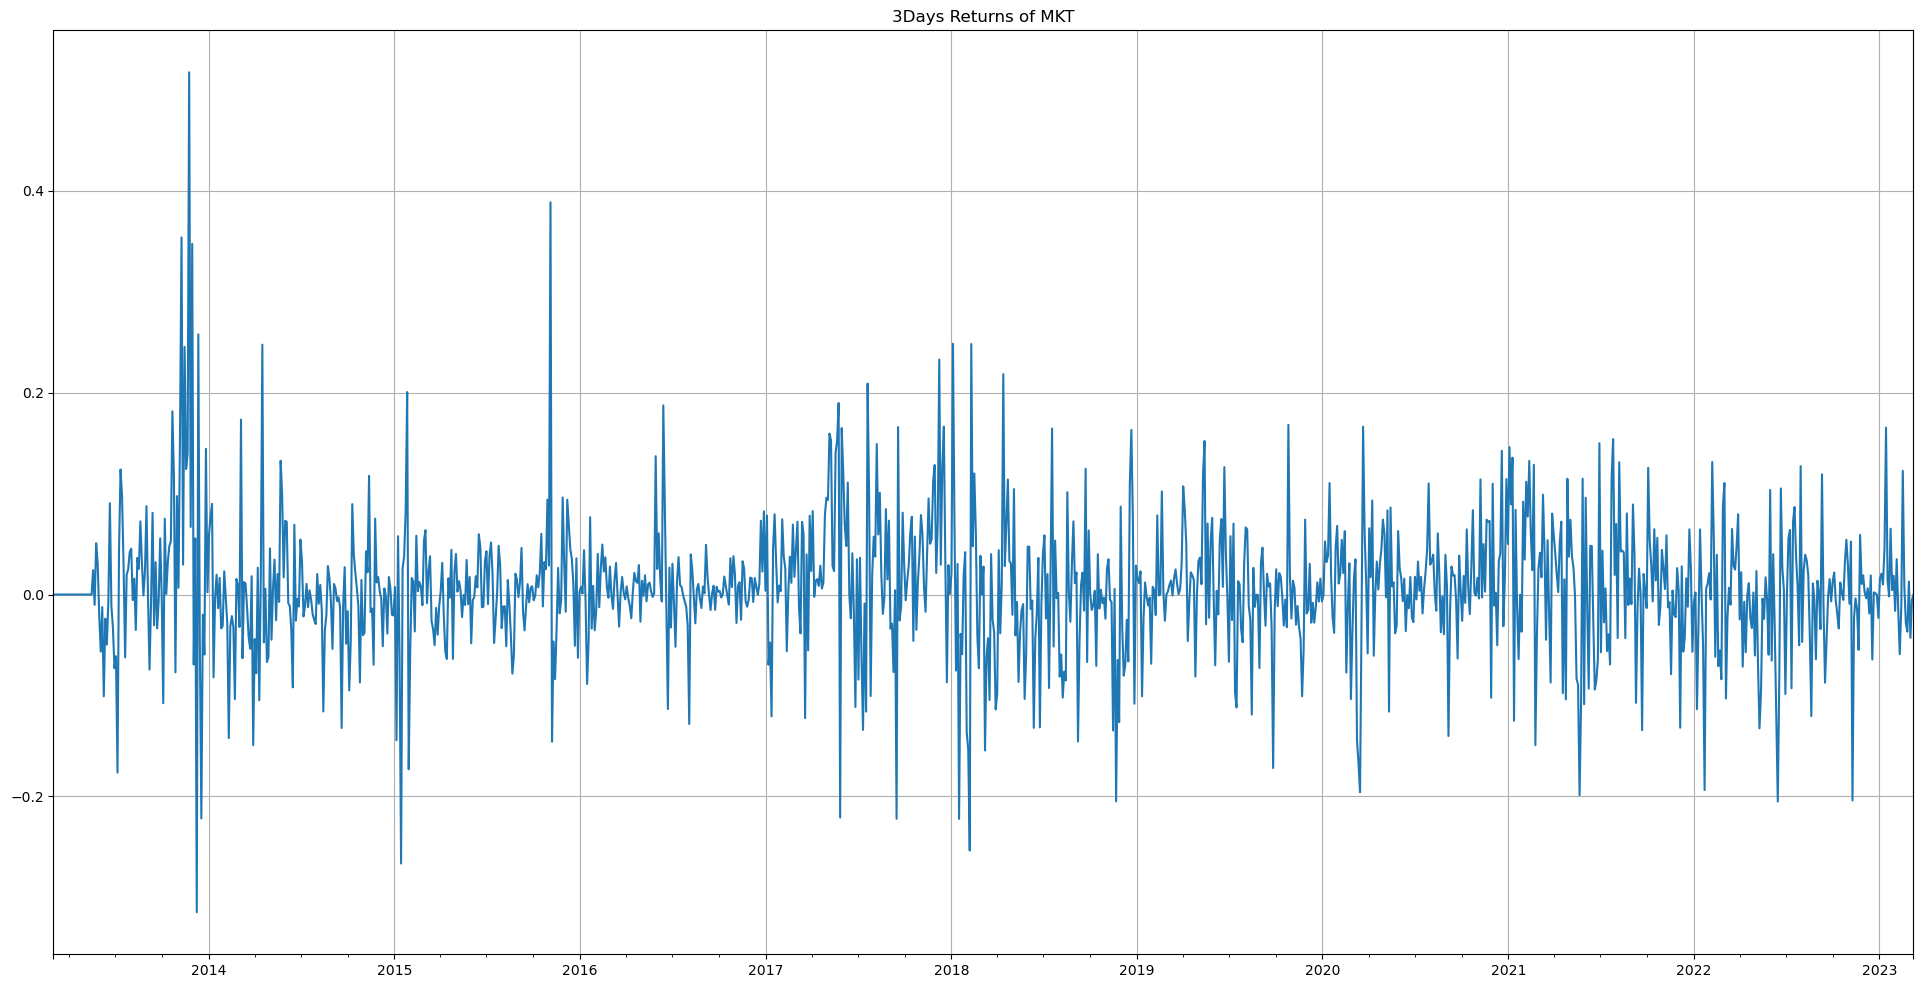

In [8]:
mkt_3days.plot(figsize=(24,12))
plt.title("3Days Returns of MKT")
plt.grid();

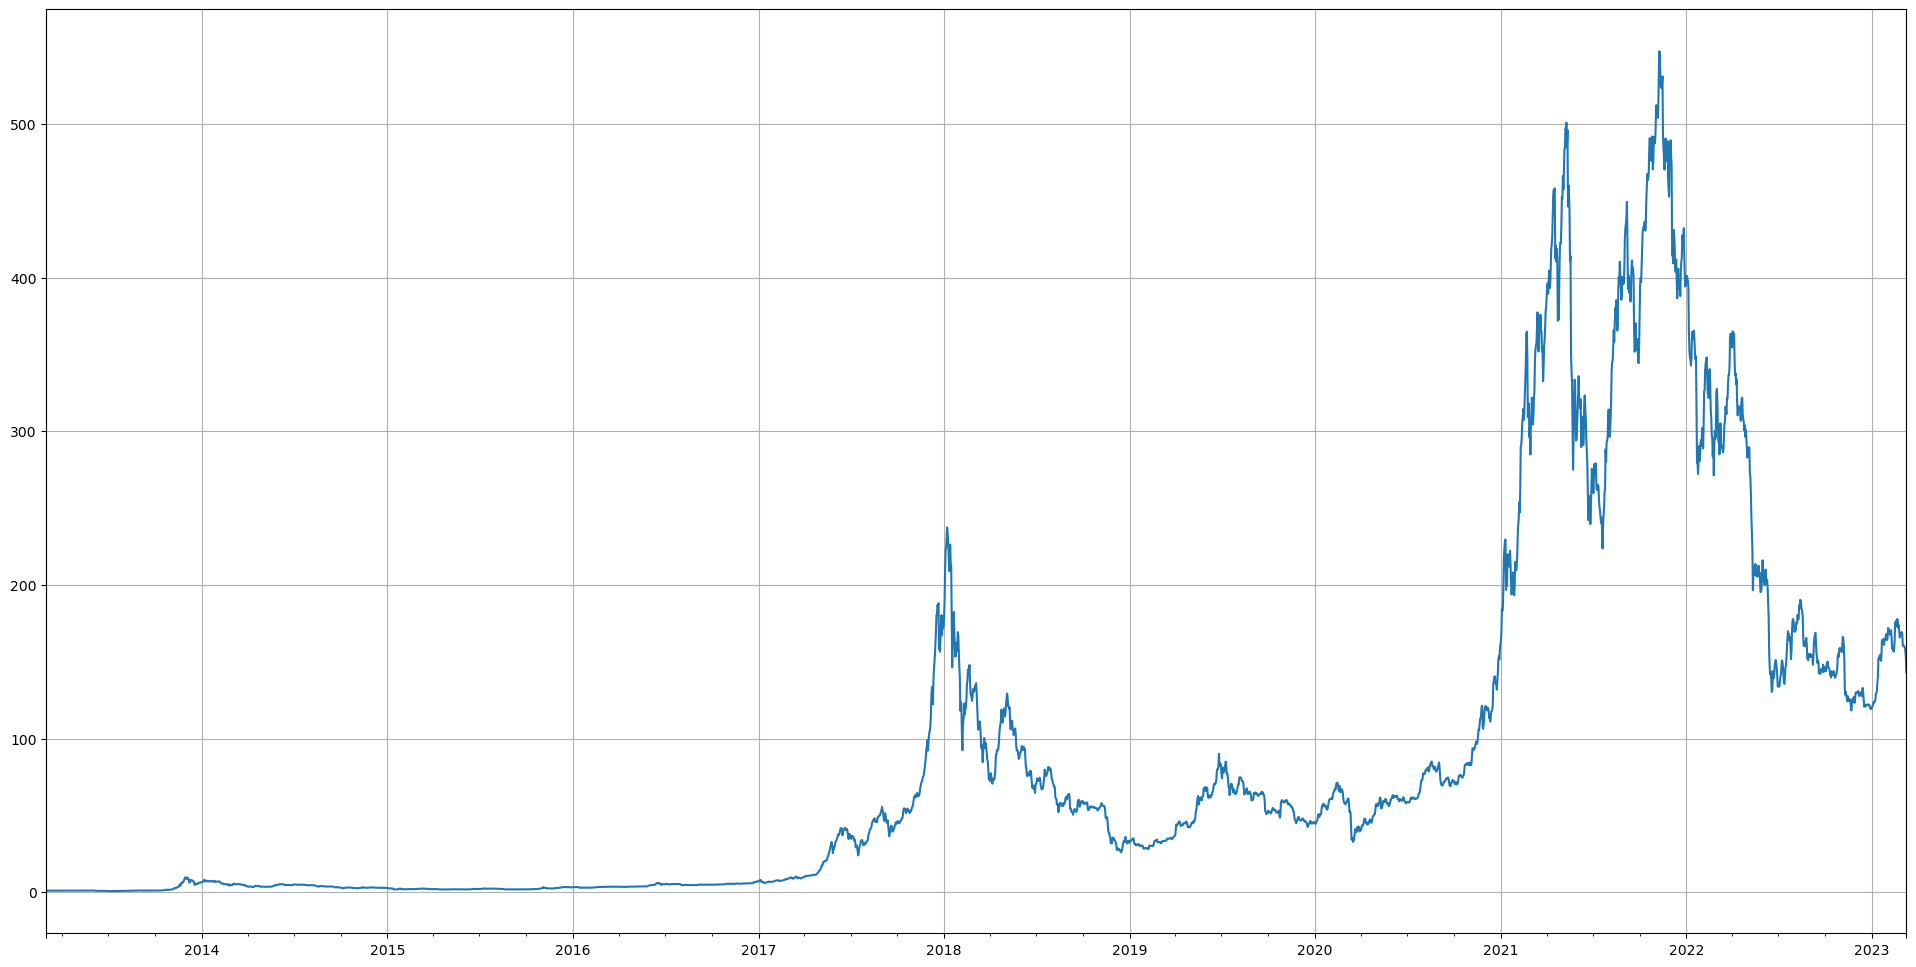

In [9]:
# mktcap으로 가중평균한 daily returns
mkt_daily = ((rtn_daily * weight_daily.shift(1)).sum(axis=1))
(mkt_daily+1).cumprod().plot(figsize=(24,12))
plt.grid();

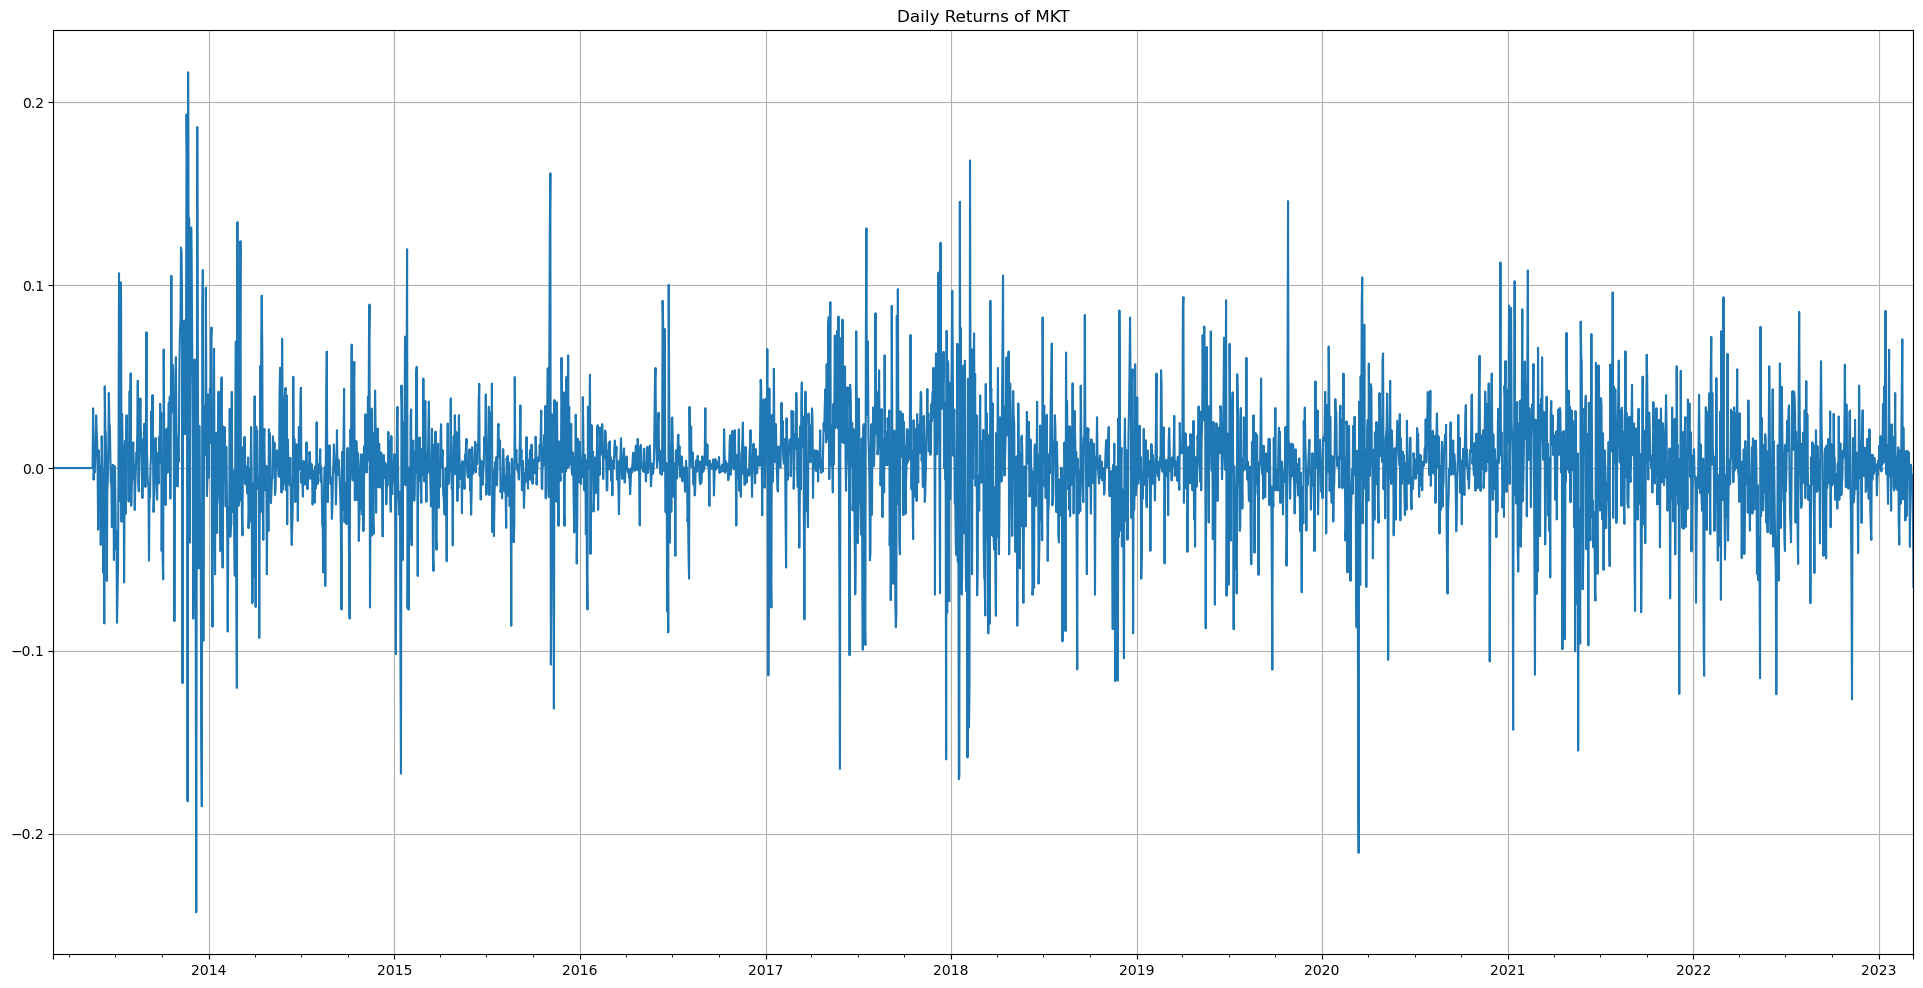

In [10]:
mkt_daily.plot(figsize=(24,12))
plt.title("Daily Returns of MKT")
plt.grid();

횡단면 회귀를 해보자

weekly_rtn, daily_rtn을 사용

5개의 그룹(모멘텀 기준)

In [ ]:
# weekly 모멘텀을 기준으로 5개의 그룹으로 나눈다
thresh = weekly_rtn.apply(lambda x: np.nanquantile(x,[0.2, 0.4, 0.6, 0.8]),
                          axis=1)
t1 = thresh.apply(lambda x: x[0])
t2 = thresh.apply(lambda x: x[1])
t3 = thresh.apply(lambda x: x[2])
t4 = thresh.apply(lambda x: x[3])

# Group별로 True/False를 담고 있다 -> Masking에 사용하면 된다
first = weekly_rtn.apply(lambda x: x <= t1, axis=0) \
                  .replace(True, 1).replace(False, np.nan)
second= weekly_rtn.apply(lambda x: (t1 < x) & (x <= t2), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
third = weekly_rtn.apply(lambda x: (t2 < x) & (x <= t3), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
four =  weekly_rtn.apply(lambda x: (t3 < x) & (x <= t4), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
five =  weekly_rtn.apply(lambda x: x > t4, axis=0) \
                  .replace(True, 1).replace(False, np.nan)

In [ ]:
# 그룹별로 시가총액 weight를 계산
weight_1 = (first * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_2 = (second * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_3 = (third * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_4 = (four * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_5 = (five * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)

In [ ]:
# 분위수 별로 들어가 있는 코인 수를 확인하자
pd.set_option("display.max_rows", 50)

num_coin = pd.concat([first.sum(1), second.sum(1), third.sum(1), 
                      four.sum(1), five.sum(1)], axis=1)

# 횡단면 코인 개수가 그룹별로 20개는 넘는 날짜를 출력하자
slice = num_coin[num_coin > 18].dropna(axis=0)
start_date = slice.index[0]
print(start_date)
slice

In [ ]:
# mktcap을 weights로 준 5개 그룹의 return
rtn1 = ((weekly_rtn * weight_1.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn2 = ((weekly_rtn * weight_2.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn3 = ((weekly_rtn * weight_3.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn4 = ((weekly_rtn * weight_4.shift(1)).loc[start_date:].iloc[:-1].sum(1))
rtn5 = ((weekly_rtn * weight_5.shift(1)).loc[start_date:].iloc[:-1].sum(1))

In [ ]:
# Q5 - Q1

q5q1 = ((rtn5 - rtn1)).loc["2018-03":]

(q5q1+1).cumprod().plot(figsize=(24,12))
plt.grid();

In [ ]:
q5q1.plot(figsize=(24,12))

In [ ]:
q5q1.mean(), q5q1.std()

In [ ]:
stats.ttest_ind(q5q1, np.zeros_like(q5q1.values))

In [ ]:
# 리턴 찍어보자
(rtn4 + 1).cumprod().plot(figsize=(24,12))
plt.title("Cross-Sectional Momentum Q4 (Weekly Return)")
plt.grid();

In [ ]:
rtn5.plot(figsize=(24,12))
plt.title("Returns of Q5")
plt.grid();

In [ ]:
# 3개 분위수로 나눠보자
thresh11 = weekly_rtn.apply(lambda x: np.nanpercentile(x, 33), axis=1)
thresh21 = weekly_rtn.apply(lambda x: np.nanpercentile(x, 66), axis=1)

low = weekly_rtn.apply(lambda x: x < thresh11.values, axis=0)\
                .replace(True, 1).replace(False, np.nan)
middle= weekly_rtn.apply(lambda x: (thresh11.values <= x) & (x < thresh21.values), axis=0) \
                  .replace(True, 1).replace(False, np.nan)
high =  weekly_rtn.apply(lambda x: x >= thresh21.values, axis=0) \
                  .replace(True, 1).replace(False, np.nan)

# 각 그룹별 weights 계산
weight_s = (low * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_m = (middle * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)
weight_h = (high * mktcap_weekly).apply(lambda x: x / np.nansum(x), axis=1)

In [ ]:
num_coin2 = pd.concat([low.sum(1),
                       middle.sum(1),
                       high.sum(1)], axis=1)#.plot()

# 횡단면 코인 개수가 그룹별로 20개는 넘는 날짜를 출력하자
slice2 = num_coin2[num_coin2 > 18].dropna(axis=0)
start_date2 = slice2.index[0]
print(start_date2)
slice2

In [ ]:
# 3개 분위수의 리턴 계산
rtn_s = ((weekly_rtn * weight_s.shift(1)).loc[start_date2:].iloc[:-1].sum(1))
rtn_m = ((weekly_rtn * weight_m.shift(1)).loc[start_date2:].iloc[:-1].sum(1))
rtn_h = ((weekly_rtn * weight_h.shift(1)).loc[start_date2:].iloc[:-1].sum(1))

In [ ]:
# 리턴 찍어보자
(rtn_h + 1).cumprod().plot(figsize=(24,12))
plt.title("Cross-Sectional Momentum High (Weekly Return)")
plt.grid();

In [ ]:
rtn_h.plot(figsize=(24,12))
plt.title("Returns of H")
plt.grid();

In [ ]:
model = OLS(rtn5, 
            add_constant(result1.loc[start_date:] \
                                .iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date:].iloc[:-1],
            rtn2)
plt.xlabel("MKT Return")
plt.ylabel("Return of Q5");

In [ ]:
model = OLS(rtn_s, 
            add_constant(result1.loc[start_date2:].iloc[:-1]))
model.fit().summary2()

In [ ]:
plt.figure(figsize=(24,12))
plt.scatter(result1.loc[start_date2:].iloc[:-1],
            rtn_h)
plt.xlabel("MKT Return")
plt.ylabel("Return of H");
#plt.ylim(-0.7,1.5);

In [ ]:
mkt_sample = result1.loc[start_date:].iloc[:-1]

In [ ]:
# 리턴이 통계적으로 다름을 보이기

# weekly MKT returns의 통계량
print("Coin MKT:", mkt_sample.mean(), mkt_sample.std())

# 5분위로 나눈 통계량
print("G1:", rtn1.mean().round(4), rtn1.std(ddof=1))
print("G2:", rtn2.mean().round(4), rtn2.std(ddof=1))
print("G3:", rtn3.mean().round(4), rtn3.std(ddof=1))
print("G4:", rtn4.mean().round(4), rtn4.std(ddof=1))
print("G5:", rtn5.mean().round(4), rtn5.std(ddof=1))

t, p_val = stats.ttest_ind(rtn4, rtn5, equal_var=False)
t, p_val

In [ ]:
def calculate_cagr(df):
    holding_year = (len(df) / 52)
    cum = (df+1).cumprod()
    cagr = (cum.iloc[-1] / cum.iloc[0]) ** (1/holding_year) -1
    print(f"The CAGR is {cagr:.2%}")
    return cagr

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample)

print("----------------")
print("Group Return")
calculate_cagr(rtn1)
calculate_cagr(rtn2)
calculate_cagr(rtn3)
calculate_cagr(rtn4)
calculate_cagr(rtn5)

In [ ]:
concat_df = pd.concat([rtn1, rtn2, rtn3, rtn4 , rtn5, mkt_sample], 
                      axis=1)
concat_df.columns = ["One","Two","Three","Four","Five","MKT"]

concat_df.corr()

In [ ]:
# 3개 그룹의 결과를 뽑자
mkt_sample2 = result1.loc[start_date2:].iloc[:-1]
rtn_s_sample = rtn_s.loc[start_date2:]
rtn_m_sample = rtn_m.loc[start_date2:]
rtn_h_sample = rtn_h.loc[start_date2:]

In [ ]:
print("S:", rtn_s_sample.mean().round(4), rtn_s_sample.std(ddof=1))
print("M:", rtn_m_sample.mean().round(4), rtn_m_sample.std(ddof=1))
print("H:", rtn_h_sample.mean().round(4), rtn_h_sample.std(ddof=1))

In [ ]:
print("Market Return")
calculate_cagr(mkt_sample2)

print("----------------")
print("Group Return")
calculate_cagr(rtn_s_sample)
calculate_cagr(rtn_m_sample)
calculate_cagr(rtn_h_sample)

In [ ]:
concat_df2 = pd.concat([rtn_s_sample, rtn_m_sample,
                        rtn_h_sample, mkt_sample2], 
                       axis=1)
concat_df2.columns = ["Low","Middle","High","MKT"]

concat_df2.corr()

In [ ]:
t, p_val = stats.ttest_ind(rtn_m_sample, 
                           rtn_h_sample)
t,p_val

In [ ]:
model = OLS(rtn_h_sample, 
            add_constant(mkt_sample2))
                            
model.fit().summary2()

In [ ]:
(result1.loc[start_date2:].iloc[:-1] +1)\
    .cumprod().plot(figsize=(24,12), label="Strategy")
(mkt_sample +1).cumprod().plot(figsize=(24,12),
                               label="MKT")
plt.legend();

* Long-Short 전략

코인 롱숏은 숏 한방을 얻어 맞고 죽는듯.....